In [18]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import joblib
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import xgboost as xgb
import os
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers, callbacks, optimizers, backend as K
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization, Add, Concatenate
from tensorflow.keras.models import Model, load_model

import keras_tuner as kt
DATA_DIR = 'data'
MODEL_DIR = 'models'
PRED_DIR = 'predictions'
# Display settings
# pd.set_option('display.max_columns', None)





def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    mask = y_true != 0
    return np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask]))



def get_unique_path(base_path):
    if not os.path.exists(base_path):
        return base_path
    name, ext = os.path.splitext(base_path)
    version = 2
    new_path = f"{name}_V{version}{ext}"
    while os.path.exists(new_path):
        version += 1
        new_path = f"{name}_V{version}{ext}"
    return new_path

def saveModel(model, fileName):
    base_path = os.path.join(MODEL_DIR, fileName)
    path = get_unique_path(base_path)

    if 'nn' in fileName:
        model.save(path)
    else:
        joblib.dump(model, path)
        

def loadModel(modelName):
    path = os.path.join(MODEL_DIR, modelName)
    if 'nn' in modelName:
        return load_model(path)
    else:
        return joblib.load(path)
    



def read_file(csvFileName):
    return pd.read_csv(DATA_DIR+'/'+csvFileName)


In [19]:
# DATA CLEANING 

def cleanColumns(data):
       # Drop 'Unnamed: 0' column
    #remove brackets
    if "Unnamed: 0" in data.columns:
        data = data.drop(["Unnamed: 0"], axis="columns")
    columns = data.columns
    data.columns =  [re.sub(r'\s*\([^)]*\)', '', col).strip() for col in columns]
    return data

def applyConstraints(data):
    return data[(data['Tank Width'] > 0) & 
                (data['Tank Length'] > 0) & 
                (data['Tank Height'] > 0) & 
                (data['Vapour Height'] >= 0) &
                (data['Vapour Temperature'] > 0) &
                (data['Liquid Temperature'] > 0)]

def standardizeStatus(data):
    data["Status"] = data["Status"].str.lower().str.replace(' ', '')
    data['Status'] = data['Status'].apply(lambda x: 'superheated' if 'h' in x else ('subcooled' if 'c' in x else x))
    return data["Status"]

def remove_outliers_iqr(df, numeric_cols):
    cleaned_df = df.copy()
    total_outliers = 0

    for col in numeric_cols:
        Q1 = cleaned_df[col].quantile(0.25)
        Q3 = cleaned_df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        outliers = cleaned_df[(cleaned_df[col] < lower_bound) | (cleaned_df[col] > upper_bound)]
        cleaned_df = cleaned_df[(cleaned_df[col] >= lower_bound) & (cleaned_df[col] <= upper_bound)]
      

        outlier_count = len(outliers)
        if outlier_count > 0:
            print(f"\nColumn: {col}")
            print(f"  IQR range: [{lower_bound:.2f}, {upper_bound:.2f}]")
            print(f"  Count of outliers: {outlier_count}")
            print(f"  Sample outlier values:\n{outliers[col].head(5).to_string(index=False)}")

        total_outliers += outlier_count

    print(f"\nTotal outliers removed: {total_outliers}")
    return cleaned_df

def clean_data(data):
    # Initial row count
    initial_rows = len(data)
    print(f"Initial rows: {initial_rows}")
   

    # Drop rows with missing values
    before_na = len(data)
    data = data.dropna(axis=0)
    after_na = len(data)
    print(f"Rows removed due to NA: {before_na - after_na}")

    # Logical constraints
    before_constraints = len(data)
    data = applyConstraints(data)
    after_constraints = len(data)
    print(f"Rows removed due to logical constraints: {before_constraints - after_constraints}")

    #Duplicates
    before_duplicates = len(data)
    data = data.drop_duplicates()
    after_duplicates = len(data)
    print(f"Rows removed as duplicates: {before_duplicates - after_duplicates}")

    # Standardize 'Status' column
    data["Status"] = standardizeStatus(data)


    numeric_cols = data.select_dtypes(include=['float64', 'int64']).columns
    before_outliers = len(data)
    data = remove_outliers_iqr(data, numeric_cols)
    after_outliers = len(data)
    print(f"Rows removed as outliers: {before_outliers - after_outliers}")

    # Final row count
    final_rows = len(data)
    print(f"Final rows: {final_rows}")
    print(f"Total rows removed after cleaning up: {initial_rows - final_rows}")
    return data





In [20]:
def feature_engineer(data):
    
    data["Liquid Boiling Temperature"] = data["Liquid Boiling Temperature"] +273.15
    data["Liquid Critical Temperature"] = data["Liquid Critical Temperature"] +273.15
    data["Tank Volume"] = data["Tank Width"] * data["Tank Length"] * data["Tank Height"]  
    data["HeightRatio"]= data["Vapour Height"] / data["Tank Height"] 
    data["Superheat Margin"] = data["Liquid Temperature"] - data["Liquid Boiling Temperature"]
    # Total Energy (approximate thermal energy in the tank)
    data["Liquid Volume"] = data["Liquid Ratio"] * data["Tank Volume"]
    data["Total Energy"] = data["Liquid Volume"] * data["Superheat Margin"]

    # (BLEVE assumed at tank center top)
    data["Sensor Distance to BLEVE"] = (
        data["Sensor Position x"]**2 +
        data["Sensor Position y"]**2 +
        (data["Sensor Position z"] - data["BLEVE Height"])**2
    ) ** 0.5
    return data


def preprocess(data,train=True,feature_eng = True):
    data = cleanColumns(data)
    if train:
        data = clean_data(data)
    data = pd.get_dummies(data, columns=["Sensor Position Side"], prefix="Side")
    data = pd.get_dummies(data, columns=["Status"], prefix="Status")
    print(data.head(1))
    if feature_eng:
        data = feature_engineer(data)
    y =  None
    if (train):
        y= data[ "Target Pressure"] 
        data = data.drop(["Target Pressure"], axis="columns")
    
    # StandardScaler for inputs
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(data)

    #split data
    if train:
        X_train, X_val, y_train, y_val = train_test_split(
            X_scaled, y, test_size=0.2, random_state=42
        )
        print("Training Set Size:", X_train.shape)
        print("Validation Set Size:", X_val.shape)
        return  X_train, X_val, y_train, y_val
    else:
        return X_scaled


In [21]:
### LOAD DATA HERE
trainData = read_file('train.csv')
trainData = preprocess(trainData,train=True,feature_eng=True)
X_train, X_val, y_train, y_val= trainData


Initial rows: 10050
Rows removed due to NA: 110
Rows removed due to logical constraints: 0
Rows removed as duplicates: 50

Column: Tank Failure Pressure
  IQR range: [-16.27, 62.29]
  Count of outliers: 48
  Sample outlier values:
1446.628788
3404.750305
1722.348566
4095.753928
2379.656661

Column: Vapour Height
  IQR range: [-0.79, 2.41]
  Count of outliers: 38
  Sample outlier values:
2.60
2.59
2.59
2.61
2.60

Column: Sensor Position y
  IQR range: [-9.47, 15.53]
  Count of outliers: 33
  Sample outlier values:
16.2
16.2
16.2
16.2
16.2

Column: Sensor Position z
  IQR range: [-9.90, 14.90]
  Count of outliers: 33
  Sample outlier values:
15.7
15.7
15.7
15.7
15.7

Column: Target Pressure
  IQR range: [-0.36, 0.88]
  Count of outliers: 882
  Sample outlier values:
1.093819
1.091484
1.036741
1.163416
1.136221

Total outliers removed: 1034
Rows removed as outliers: 1034
Final rows: 8856
Total rows removed after cleaning up: 1194
   Tank Failure Pressure  Liquid Ratio  Tank Width  Tank Le

In [ ]:




def plot_grid_search_table(grid_search,modelName, metric='mean_test_score', top_n=20):
    # Extract and sort results
    results = pd.DataFrame(grid_search.cv_results_)
    results = results.sort_values(by=metric, ascending=False).head(top_n)

    # Get only param columns and the score
    table_data = results.filter(like='param_').copy()
    table_data[metric] = results[metric].values

    # Reset index for clean display
    table_data.reset_index(drop=True, inplace=True)

    # Convert all values to string for uniform display
    table_data = table_data.astype(str)

    # Plot table as figure
    fig, ax = plt.subplots(figsize=(min(25, table_data.shape[1]*2), top_n * 0.5 + 1))
    ax.axis('off')

    table = ax.table(cellText=table_data.values,
                     colLabels=table_data.columns,
                     cellLoc='center',
                     loc='center')

    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1, 1.5)

    plt.title(f"Top {top_n} GridSearchCV {modelName} Results by {metric}", fontsize=14)
    plt.tight_layout()
    plt.show()


def summarize_results(model,name):
    y_pred = model.predict(X_val)
    # Compute metrics
    mse = mean_squared_error(y_val, y_pred)
    r2 = r2_score(y_val, y_pred)

    print(f"MSE: {mse:.4f}")
    print(f"R²: {r2:.4f}")
    summary = {
        'Model': name,
        'MSE': mse,
        'R2': r2,
        'Best Params': str(model.getparams())
    }
    return pd.DataFrame([summary])

from sklearn.pipeline import Pipeline
import xgboost as xgb
from sklearn.model_selection import GridSearchCV

def train_xgboost():
    # param_grid = {
    #     'n_estimators': [100, 300, 500],
    #     'max_depth': [3, 6, 9],
    #     'learning_rate': [0.01, 0.1, 0.3],
    #     'subsample': [0.8],
    #     'colsample_bytree': [0.8],
    #     'min_child_weight': [1],
    #     'reg_lambda': [1],
    #     'reg_alpha': [0]
    # }
    ## Fine TUnning
    param_grid = {
    'n_estimators': [700],
    'max_depth': [6],
 'learning_rate': [0.08,0.085],
    'subsample': [0.8],
    'colsample_bytree': [0.8,0.9,0.85],
    'colsample_bylevel': [0.8,0.9,0.85],
    'gamma': [0],
    'min_child_weight': [3],
    'reg_lambda': [0,0.3,0.6],
    'reg_alpha': [0.2,0.15,0.1]
}
  

    model = xgb.XGBRegressor(objective="reg:squarederror", random_state=42)
    grid_search = GridSearchCV(model, param_grid=param_grid, cv=3, scoring='neg_mean_squared_error', verbose=1, n_jobs=-1)

 


    grid_search.fit(X_train, y_train)

    best_model = grid_search.best_estimator_
    return best_model , grid_search


def train_svr():

    pipeline = Pipeline([
        ('svr', SVR(cache_size=1000))
    ])
    

   
    #intial grid
        # param_grid = [
        #     {
        #         'svr__kernel': ['rbf'],
        #         'svr__C': [0.1, 1.0, 10.0, 100.0, 1000.0],
        #         'svr__epsilon': [0.001, 0.01, 0.1, 0.5],
        #         'svr__gamma': ['scale', 'auto', 0.001, 0.01, 0.1, 1.0]
        #     },
        #     {
        #         'svr__kernel': ['poly'],
        #         'svr__C': [0.1, 1.0, 10.0, 100.0],
        #         'svr__epsilon': [0.001, 0.01, 0.1],
        #         'svr__gamma': ['scale', 'auto', 0.01, 0.1],
        #         'svr__degree': [2, 3, 4],
        #         'svr__coef0': [0.0, 0.1, 1.0]
        #     },
        # ]
        # precirse tuning
    param_grid = [{
                'svr__kernel': ['rbf'],
                'svr__C': [3.2,3,3.5,3.8],
                'svr__epsilon': [0.01,0.015,0.009],
                'svr__gamma': ['scale']
            }]
        
    grid_search = GridSearchCV(
        pipeline, 
        param_grid=param_grid,
        cv=4,  
        scoring='neg_mean_squared_error',
        verbose=1, 
        n_jobs=-1,
        return_train_score=True
    )
    
    grid_search.fit(X_train, y_train)
    
    # Print best parameters for easy reference
    print(f"Best parameters: {grid_search.best_params_}")
    print(f"Best score: {-grid_search.best_score_:.6f}")
    
    return grid_search.best_estimator_, grid_search






IndentationError: unexpected indent (3005991922.py, line 118)

In [ ]:
svr_model, grid_search_svr = train_svr()



Fitting 4 folds for each of 12 candidates, totalling 48 fits


Best parameters: {'svr__C': 3.5, 'svr__epsilon': 0.01, 'svr__gamma': 'scale', 'svr__kernel': 'rbf'}
Best score: 0.002348


{'memory': None, 'steps': [('svr', SVR(C=3.5, cache_size=1000, epsilon=0.01))], 'transform_input': None, 'verbose': False, 'svr': SVR(C=3.5, cache_size=1000, epsilon=0.01), 'svr__C': 3.5, 'svr__cache_size': 1000, 'svr__coef0': 0.0, 'svr__degree': 3, 'svr__epsilon': 0.01, 'svr__gamma': 'scale', 'svr__kernel': 'rbf', 'svr__max_iter': -1, 'svr__shrinking': True, 'svr__tol': 0.001, 'svr__verbose': False}


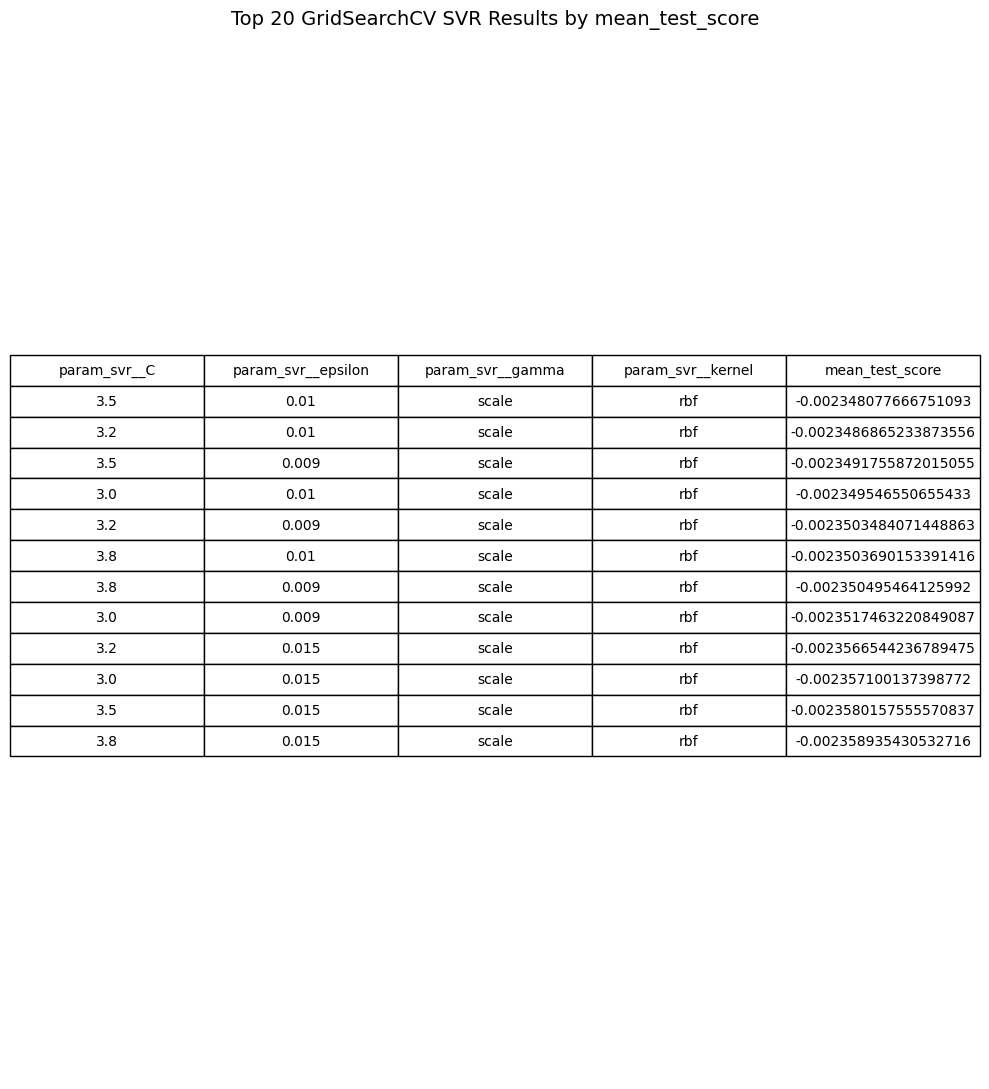

In [ ]:

print(svr_model.get_params())
plot_grid_search_table(grid_search_svr,"SVR")
saveModel(svr_model,'svr-best.pkl')

Fitting 3 folds for each of 162 candidates, totalling 486 fits


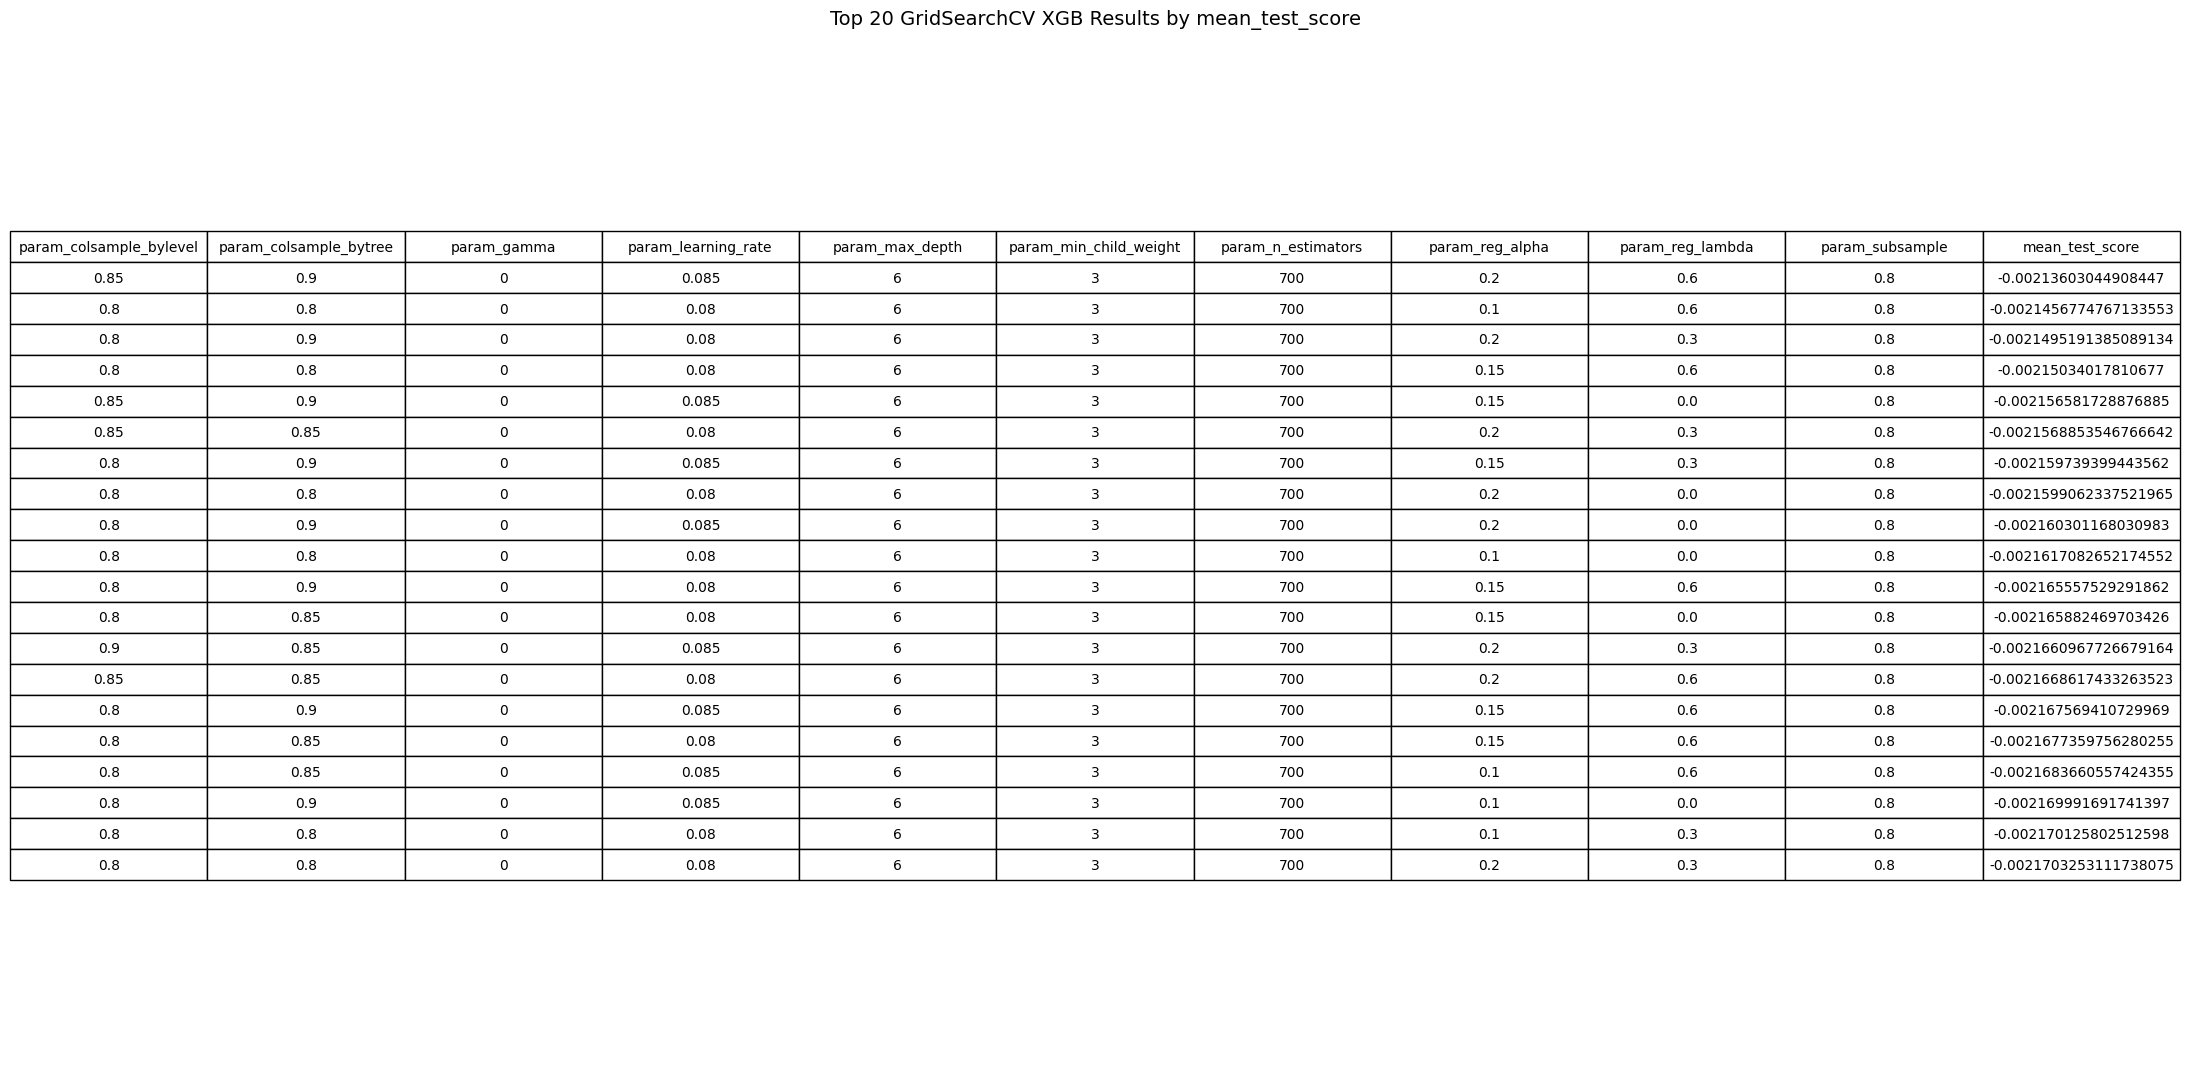

In [ ]:
xgb_model,grid_search = train_xgboost()


plot_grid_search_table(grid_search,"XGB")



In [ ]:
saveModel(xgb_model,'xgb-final.pkl')

In [6]:
# Neural network
def mish(x):
    return x * tf.math.tanh(tf.math.softplus(x))


import tensorflow as tf
from tensorflow.keras import layers, models, regularizers, callbacks, optimizers
import matplotlib.pyplot as plt


def build_nn():
    model = models.Sequential([
        layers.Dense(512, activation='swish', input_shape=(X_train.shape[1],),
                     kernel_regularizer=regularizers.l2(1e-5)),
        layers.BatchNormalization(),
        layers.Dropout(0.2),

        layers.Dense(512, activation='swish', kernel_regularizer=regularizers.l2(1e-5)),
        layers.BatchNormalization(),
        layers.Dropout(0.2),

        layers.Dense(256, activation='swish', kernel_regularizer=regularizers.l2(1e-5)),
        layers.BatchNormalization(),
        layers.Dropout(0.2),

        layers.Dense(128, activation='swish', kernel_regularizer=regularizers.l2(1e-5)),
        layers.BatchNormalization(),
        layers.Dropout(0.1),

        layers.Dense(1)  # Linear output for regression
    ])

    optimizer = optimizers.Adam(learning_rate=0.001)
    model.compile(optimizer=optimizer,
                  loss='mape',
                  metrics=['mae', tf.keras.metrics.MeanAbsolutePercentageError()])
    return model




def plot_nn(history):
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training & Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot Training & Validation MAE
    plt.subplot(1, 2, 2)
    plt.plot(history.history['mae'], label='Training MAE')
    plt.plot(history.history['val_mae'], label='Validation MAE')
    plt.title('Training & Validation MAE')
    plt.xlabel('Epochs')
    plt.ylabel('Mean Absolute Error')
    plt.legend()

    # Show the plots
    plt.tight_layout()
    plt.show()


def train_nn(model):
    early_stop = callbacks.EarlyStopping(
        monitor='val_loss', patience=100, restore_best_weights=True
    )
    history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=500,
    batch_size=32,
    callbacks=[early_stop],
    verbose=2)
    plot_nn(history)
    return history






nn_model = build_nn()


/home/21827840/uni/ML/assignment/tf/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1746440115.884758 2057403 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 10223 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3060, pci bus id: 0000:01:00.0, compute capability: 8.6


Epoch 1/500


I0000 00:00:1746440188.852705 2066717 service.cc:152] XLA service 0x7886f00070a0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1746440188.852725 2066717 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 3060, Compute Capability 8.6
2025-05-05 18:16:28.890076: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1746440189.081735 2066717 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1746440190.158419 2066717 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


237/237 - 5s - 23ms/step - loss: 372.4383 - mae: 0.5433 - mean_absolute_percentage_error: 372.4269 - val_loss: 100.6021 - val_mae: 0.2094 - val_mean_absolute_percentage_error: 100.5908
Epoch 2/500
237/237 - 1s - 5ms/step - loss: 143.8785 - mae: 0.2588 - mean_absolute_percentage_error: 143.8672 - val_loss: 49.9539 - val_mae: 0.1296 - val_mean_absolute_percentage_error: 49.9425
Epoch 3/500
237/237 - 1s - 6ms/step - loss: 84.9716 - mae: 0.1785 - mean_absolute_percentage_error: 84.9602 - val_loss: 31.9800 - val_mae: 0.0941 - val_mean_absolute_percentage_error: 31.9686
Epoch 4/500
237/237 - 1s - 6ms/step - loss: 62.9006 - mae: 0.1450 - mean_absolute_percentage_error: 62.8891 - val_loss: 33.6377 - val_mae: 0.0928 - val_mean_absolute_percentage_error: 33.6262
Epoch 5/500
237/237 - 1s - 6ms/step - loss: 47.2442 - mae: 0.1216 - mean_absolute_percentage_error: 47.2328 - val_loss: 28.3534 - val_mae: 0.0926 - val_mean_absolute_percentage_error: 28.3420
Epoch 6/500
237/237 - 1s - 5ms/step - loss: 4

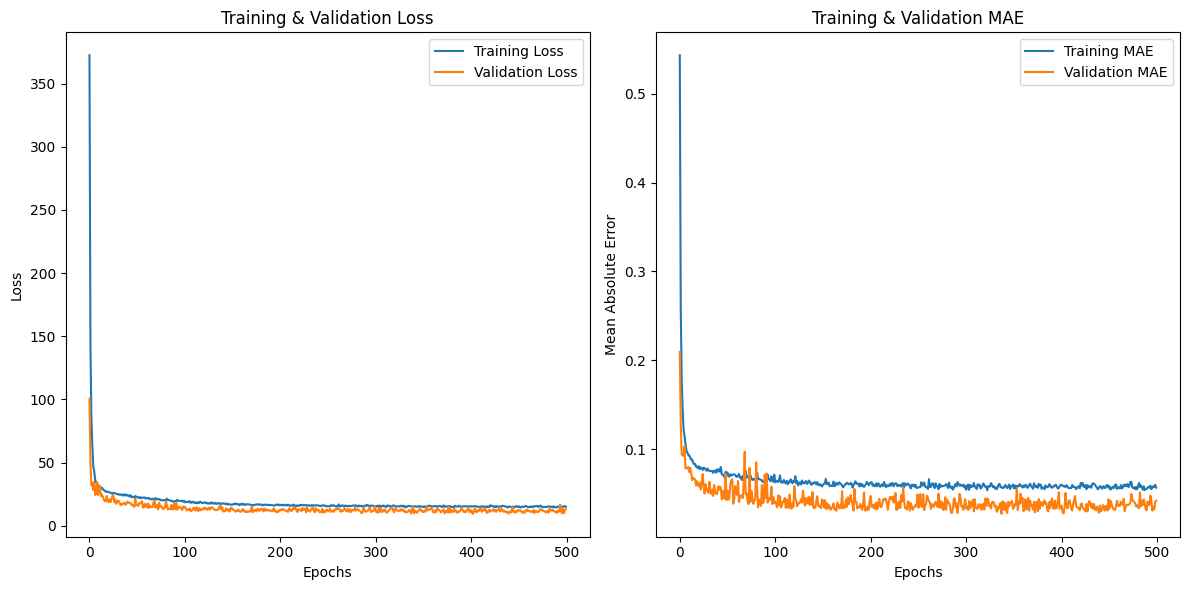

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - loss: 9.3094 - mae: 0.0274 - mean_absolute_percentage_error: 8.9615


ValueError: too many values to unpack (expected 2)

In [7]:


history = train_nn(nn_model)

val_loss, val_mae = history.model.evaluate(X_val, y_val, batch_size=512, verbose=1)

# Print the results
print(f"Validation Loss: {val_loss}")
print(f"Validation MAE: {val_mae}")

In [9]:
print(history.model)
saveModel(history.model,'lastnn.keras')

<Sequential name=sequential, built=True>


60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


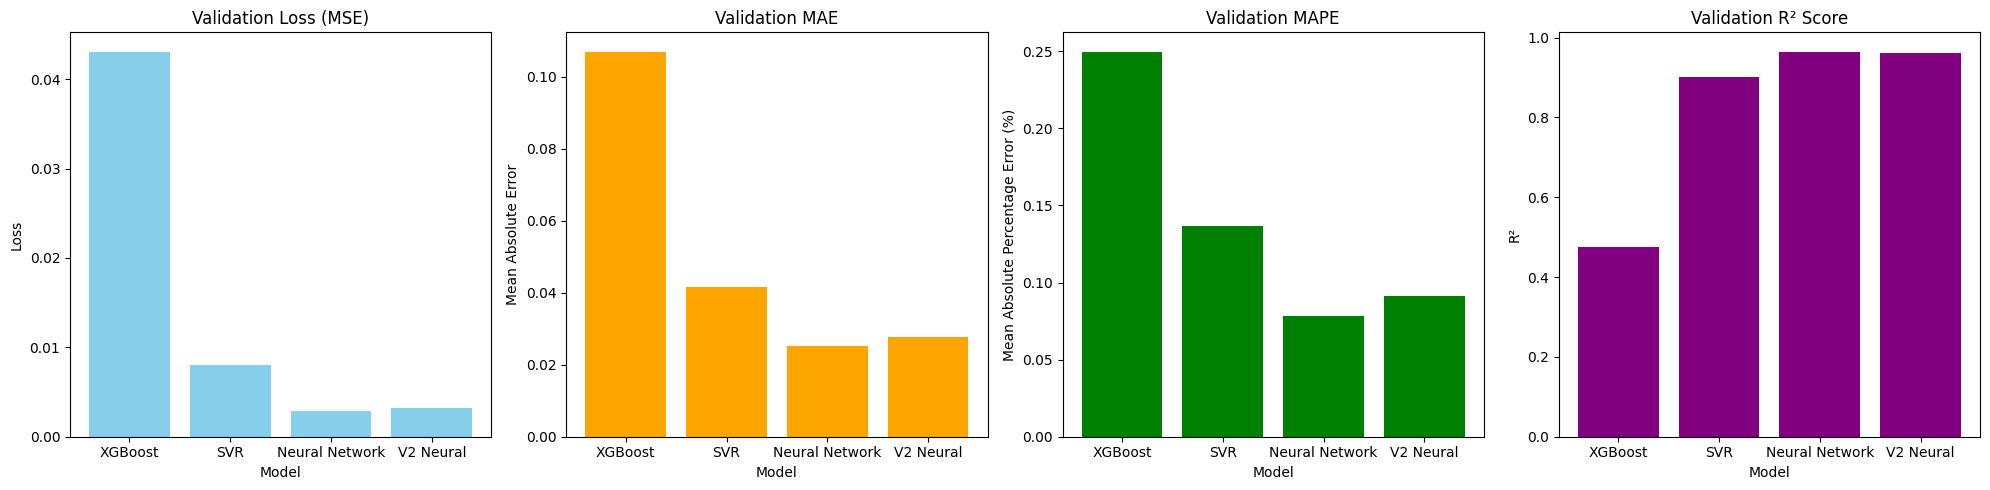

In [13]:


# Assuming models array contains [xgb_model, svr_model]
svr_model = loadModel('best/svr.pkl')
xgb_model = loadModel('best/xgb.pkl')
nn_model = loadModel('test3.keras')
v2_nn = loadModel('lastnn.keras')
models = [xgb_model, svr_model,nn_model,v2_nn]
model_names = ["XGBoost", "SVR",'Neural Network',"V2 Neural"]

# Initialize lists to store metrics
val_losses = []
val_maes = []
val_mapes = []
val_r2s = []

# Loop through models and calculate metrics
for model in models:
    y_pred = model.predict(X_val).flatten()  # Ensure predictions are 1D
    val_loss = mean_squared_error(y_val, y_pred)
    val_mae = mean_absolute_error(y_val, y_pred)
    val_mape = mean_absolute_percentage_error(y_val, y_pred)
    val_r2 = r2_score(y_val, y_pred)

    val_losses.append(val_loss)
    val_maes.append(val_mae)
    val_mapes.append(val_mape)
    val_r2s.append(val_r2)

# Create subplots for all metrics
plt.figure(figsize=(20, 5))

# Histogram for val_loss
plt.subplot(1, 4, 1)
plt.bar(model_names, val_losses, color='skyblue')
plt.title("Validation Loss (MSE)")
plt.ylabel("Loss")
plt.xlabel("Model")

# Histogram for val_mae
plt.subplot(1, 4, 2)
plt.bar(model_names, val_maes, color='orange')
plt.title("Validation MAE")
plt.ylabel("Mean Absolute Error")
plt.xlabel("Model")

# Histogram for val_mape
plt.subplot(1, 4, 3)
plt.bar(model_names, val_mapes, color='green')
plt.title("Validation MAPE")
plt.ylabel("Mean Absolute Percentage Error (%)")
plt.xlabel("Model")

# Histogram for R^2
plt.subplot(1, 4, 4)
plt.bar(model_names, val_r2s, color='purple')
plt.title("Validation R² Score")
plt.ylabel("R²")
plt.xlabel("Model")

plt.tight_layout()
plt.show()


In [ ]:





def test_model(model,modelName):
    test_data = read_file('test.csv')
    y_ID =read_file('sample_prediction.csv')
    test_scaled = preprocess(data=test_data, train=False, feature_eng=True)
    y_pred = model.predict(test_scaled).flatten()
    output_df = pd.DataFrame({
    'ID': y_ID['ID'], 
    'Target Pressure (bar)': y_pred 
})
    fileName = get_unique_path(os.path.join(PRED_DIR,f'{modelName}_pred.csv'))
    output_df.to_csv(fileName, index=False)
    print(f'Predictions have been saved to ${fileName}.')


for i in range(len(models)):
    test_model(models[i],model_names[i])




   Tank Failure Pressure  Liquid Ratio  Tank Width  Tank Length  Tank Height  \
0                   37.9      0.412227         0.8          6.6          0.4   

   BLEVE Height  Vapour Height  Vapour Temperature  Liquid Temperature  \
0           0.8            0.2               317.6               337.5   

   Obstacle Distance to BLEVE  ...  Sensor Position x  Sensor Position y  \
0                           7  ...               8.05               -4.3   

   Sensor Position z  Side_1  Side_2  Side_3  Side_4  Side_5  \
0               -0.7    True   False   False   False   False   

   Status_Subcooled  Status_Superheated  
0              True               False  

[1 rows x 28 columns]
Predictions have been saved to $predictions/XGBoost_pred_V8.csv.
   Tank Failure Pressure  Liquid Ratio  Tank Width  Tank Length  Tank Height  \
0                   37.9      0.412227         0.8          6.6          0.4   

   BLEVE Height  Vapour Height  Vapour Temperature  Liquid Temperature  \
0

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, regularizers, callbacks
import keras_tuner as kt

# Custom Mish activation
def mish(x):
    return x * tf.math.tanh(tf.math.softplus(x))

tf.keras.utils.get_custom_objects().update({'mish': mish})

# Model builder with your original structure
def build_model(hp):
    model = models.Sequential()

    # First Dense layer (input layer)
    model.add(layers.Dense(
        units=hp.Choice('units1', [128, 256, 512]),
        activation='mish',
        input_shape=(X_train.shape[1],),
        kernel_regularizer=regularizers.l2(hp.Choice('l2_reg', [1e-5, 1e-4]))
    ))
    model.add(layers.Dropout(hp.Float('dropout1', 0.1, 0.3, step=0.1)))

    # Second Dense layer
    model.add(layers.Dense(
        units=hp.Choice('units2', [128, 256, 512]),
        activation='mish',
        kernel_regularizer=regularizers.l2(hp.Choice('l2_reg', [1e-5, 1e-4]))
    ))
    model.add(layers.Dropout(hp.Float('dropout2', 0.1, 0.3, step=0.1)))

    # Third Dense layer
    model.add(layers.Dense(
        units=hp.Choice('units3', [128, 256, 512]),
        activation='mish',
        kernel_regularizer=regularizers.l2(hp.Choice('l2_reg', [1e-5, 1e-4]))
    ))
    model.add(layers.Dropout(hp.Float('dropout3', 0.1, 0.3, step=0.1)))

    # Output layer
    model.add(layers.Dense(1, activation='softplus'))

    # Optimizer
    optimizer_choice = hp.Choice('optimizer', ['sgd', 'adam'])
    if optimizer_choice == 'sgd':
        opt = optimizers.SGD(
            learning_rate=hp.Choice('learning_rate', [0.01, 0.05, 0.1]),
            momentum=hp.Float('momentum', 0.6, 0.95, step=0.05)
        )
    else:
        opt = optimizers.Adam(
            learning_rate=hp.Choice('learning_rate', [0.001, 0.005, 0.01])
        )

    model.compile(optimizer=opt, loss='mse', metrics=['mae'])
    return model

# Keras Tuner setup
tuner = kt.RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=20,
    executions_per_trial=1,
    directory='tuner_dir',
    project_name='mish_nn_tuned'
)

# Start search
tuner.search(
    X_train, y_train,
    epochs=100,
    validation_data=(X_val, y_val),
    callbacks=[callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)],
    verbose=1
)

# Retrieve best model and hyperparameters
best_model = tuner.get_best_models(num_models=1)[0]
best_hps = tuner.get_best_hyperparameters(1)[0]

# Print best hyperparameters
print("Best hyperparameters:")
for key in best_hps.values:
    print(f"{key}: {best_hps.get(key)}")


Trial 1 Complete [00h 00m 47s]
val_loss: 0.015352827496826649

Best val_loss So Far: 0.015352827496826649
Total elapsed time: 00h 00m 47s

Search: Running Trial #2

Value             |Best Value So Far |Hyperparameter
128               |256               |units1
0.0001            |0.0001            |l2_reg
0.4               |0.3               |dropout1
256               |256               |units2
0.1               |0.3               |dropout2
512               |256               |units3
0.5               |0.5               |dropout3
adam              |sgd               |optimizer
0.1               |0.05              |learning_rate
0.75              |0.75              |momentum

Epoch 1/100


/home/21827840/uni/ML/assignment/tf/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


222/222 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 4524.3389 - mae: 3.3970 - val_loss: 17.0501 - val_mae: 0.2473
Epoch 2/100
222/222 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 17.0328 - mae: 0.2452 - val_loss: 16.9850 - val_mae: 0.2473
Epoch 3/100
222/222 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 16.9611 - mae: 0.2411 - val_loss: 16.9050 - val_mae: 0.2473
Epoch 4/100
222/222 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 16.8774 - mae: 0.2409 - val_loss: 16.8122 - val_mae: 0.2473
Epoch 5/100
222/222 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 16.7782 - mae: 0.2360 - val_loss: 16.7073 - val_mae: 0.2473
Epoch 6/100
213/222 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 16.6760 - mae: 0.2417

KeyboardInterrupt: 

In [ ]:
from scikeras.wrappers import KerasRegressor
from sklearn.model_selection import GridSearchCV

def build_nn_model(optimizer='adam', dropout_rate=0.1, lr=0.001):
    def mish(x):
        return x * tf.math.tanh(tf.math.softplus(x))

    
    model = models.Sequential([
        layers.Dense(256, activation='mish', input_shape=(X_train.shape[1],),
                     kernel_regularizer=regularizers.l2(1e-5)),
        layers.Dropout(dropout_rate),
        layers.Dense(256, activation='mish', kernel_regularizer=regularizers.l2(1e-5)),
        layers.Dropout(dropout_rate),
        layers.Dense(256, activation='mish', kernel_regularizer=regularizers.l2(1e-5)),
        layers.Dropout(dropout_rate),
        layers.Dense(1, activation='softplus')
    ])

    if optimizer == 'adam':
        opt = tf.keras.optimizers.Adam(learning_rate=lr)
    else:
        opt = tf.keras.optimizers.SGD(learning_rate=lr, momentum=0.9)

    model.compile(optimizer=opt, loss='mse', metrics=['mae'])
    return model
regressor = KerasRegressor(model=build_nn_model, verbose=0, epochs=100, batch_size=32)

param_grid = {
    'model__optimizer': ['adam', 'sgd'],
    'model__dropout_rate': [0.1, 0.3],
    'model__lr': [0.01, 0.001],
    'batch_size': [32, 64],
    'epochs': [100]
}
grid = GridSearchCV(estimator=regressor, param_grid=param_grid,
                    scoring='neg_mean_squared_error', cv=3, verbose=2, n_jobs=-1)

grid_result = grid.fit(X_train, y_train)

print("Best params:", grid_result.best_params_)
print("Best score (neg MSE):", grid_result.best_score_)

best_model = grid_result.best_estimator_
y_pred = best_model.predict(X_val)
mse = mean_squared_error(y_val, y_pred)
mae = mean_absolute_error(y_val, y_pred)
r2 = r2_score(y_val, y_pred)

print(f"MSE: {mse:.4f}, MAE: {mae:.4f}, R²: {r2:.4f}")



AttributeError: 'super' object has no attribute '__sklearn_tags__'

Fitting 3 folds for each of 162 candidates, totalling 486 fits


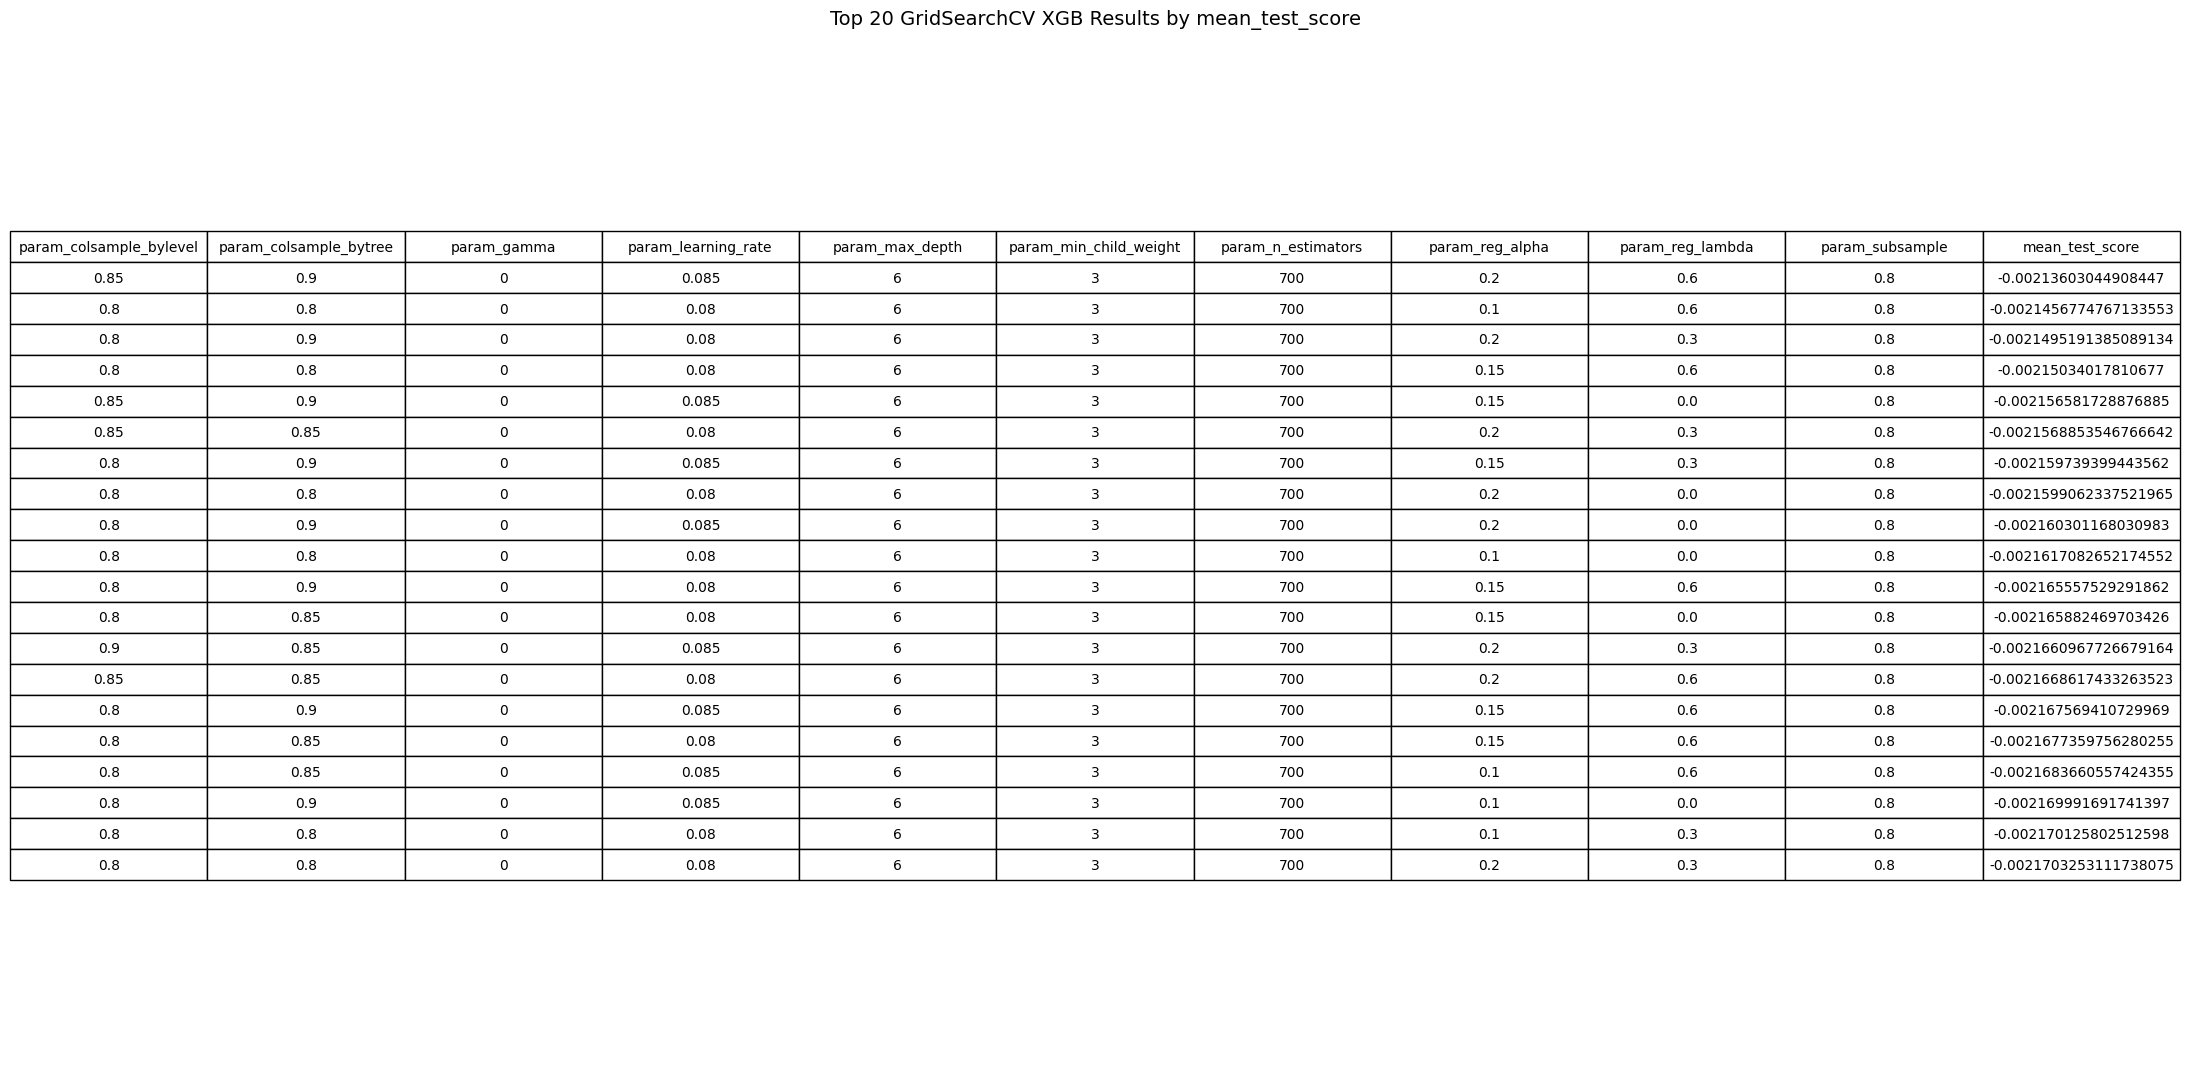

In [ ]:
xgb_model,grid_search = train_xgboost()


plot_grid_search_table(grid_search,"XGB")

